In [19]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

import scanpy as sc
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import glob

### Random baseline

In [20]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def return_hits(list_):
    return list(set(list_).intersection(set(topmovers)))

def get_all_sampled_genes(exp_path):
    all_sampled_genes = []
    num_rounds = len(glob.glob(exp_path + '*'))
    for i in range(num_rounds):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr):
    return list(set(arr).intersection(set(topmovers)))

In [21]:
REPS = np.arange(1, 10).astype('str')
ACQUISITION_FUNCTIONS = ["random", "softuncertain", "topuncertain",
                         "marginsample", "coreset", "badge",
                         "kmeans_embedding", "kmeans_data"]

dataset = 'sanchez'
sample_size= 128
num_steps = 5

data_name_map = {'scharenberg': 'Scharenberg22',
                 'ifng': 'IFNG',
                 'il2': 'IL2',
                 'steinhart': 'Steinhart_crispra_GD2_D22',
                 'scharenberg': 'Scharenberg22',
                 'sanchez': 'Sanchez21_down',
                 'carnevale_adenosine': 'Carnevale22_Adenosine'}

result_name_map = {'scharenberg': 'scharenberg_2022',
                 'ifng': 'Schmidt_2021_ifng',
                 'il2': 'Schmidt_2021_il2',
                 'steinhart': 'steinhart_2024_crispra_GD2_D22',
                 'scharenberg': 'scharenberg_2022',
                 'sanchez': 'sanchez_2021_down',
                  'carnevale_adenosine': 'Carnevale_2022_Adenosine'}

    
num_reps = len(REPS)
batch_size=sample_size

data_df = pd.read_csv('/dfs/user/yhr/AI_RA/research_assistant/datasets/ground_truth_'+data_name_map[dataset]+'.csv')
topmovers = np.load('/dfs/user/yhr/AI_RA/research_assistant/datasets/topmovers_'+data_name_map[dataset]+'.npy')
try:
    data_df = data_df.rename(columns={'0':'Gene', '1':'Score'})
except:
    pass

all_genes = data_df['Gene'].values
data_df = data_df.set_index('Gene')

### ML model results

In [22]:
## For steinhart

#data_name = 'schmidt_2021_ifng_noise'
#data_name = 'belk_2022'
data_name = result_name_map[dataset]

def read_ml_rounds(data_name, num_steps, batch_size):
    #path = f'/dfs/user/yhr/genedisco/genedisco/results/Schmidt_2021_'+data_name+'/'
    
    ## special path for steinhart
    path = f'/dfs/user/yhr/genedisco/genedisco/results/'+data_name+'/'
    print(path)
    all_pred_genes = []
    for i in range(num_steps):
        try:
            all_pred_genes.append(pd.read_pickle(path+'cycle_{}/selected_indices.pickle'.format(i)))
        except:
            print('No sampling round {}'.format(i))
    return all_pred_genes

def get_ml_hits(data_name, ML_model_name, num_steps = num_steps, 
                batch_size=batch_size,
                num_reps=2):
    
    ml_rounds = {}
    ml_hits = {}
    ml_hit_rates = {}
    
    for rep in range(1, num_reps+1):
        rep=str(rep)
        ml_rounds[rep] = read_ml_rounds(data_name + '_' + ML_model_name + '_{}'.format(rep), 
                                        num_steps, batch_size=batch_size)

        ml_hits[rep] = []
        ml_hit_rates[rep] = []
        for step in range(num_steps):
            ml_hits[rep].append(return_hits(ml_rounds[rep][step]))
            ml_hit_rates[rep].append(len(ml_hits[rep][-1])/len(topmovers))
        
    return ml_hit_rates, ml_hits


def get_random_hits(sample_size, num_steps = num_steps, num_reps=3):
    random_rounds = {}
    random_hits = {}
    random_hit_rates = {}

    for rep in range(1, num_reps+1):
        rep=str(rep)
        random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
        #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
        #                                                   sample_sizes=sample_sizes[rep])

        random_hits[rep] = []
        random_hit_rates[rep] = []
        for step in range(num_steps):
            random_hits[rep].append(return_hits(random_rounds[rep][step]))
            random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
            
    return random_hit_rates, random_hits

def get_avg_hit_score(hits):
    return data_df.loc[hits].abs().mean().values[0]

def get_avg_hit_scores(hits, num_reps=3):
    hit_scores = []
    
    for rep in range(1, num_reps+1):
        hit_score_rep = []
        for hit_list in hits[str(rep)]:
            hit_score_rep.append(get_avg_hit_score(hit_list))
        hit_scores.append(hit_score_rep)

    return np.round(np.nanmean(np.array(hit_scores), 0),3)

In [23]:
# calculate the mean and standard deviation of the random data
random_hit_rates, random_hits = get_random_hits(sample_size, num_steps = num_steps, num_reps=num_reps)
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

# calculate the mean and standard deviation for the model predictions
ml_mean = {}
ml_std = {}
ml_scores = {}

for ML_model_name in ACQUISITION_FUNCTIONS:
    
    print(ML_model_name)
    
    try:
        ml_hit_rates, ml_hits = get_ml_hits(data_name, ML_model_name, num_steps = num_steps, 
                                            num_reps=num_reps,
                                            batch_size=batch_size)
        ml_scores[ML_model_name] = get_avg_hit_scores(ml_hits, num_reps=num_reps)
        
        ml_mean[ML_model_name] = np.round(np.mean(np.array([x for x in ml_hit_rates.values()]),0),3)
        ml_std[ML_model_name] = np.round(np.std(np.array([x for x in ml_hit_rates.values()]),0),3)
    except:
        print('Failed')

random
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_1/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_2/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_3/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_4/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_5/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_6/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_7/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_8/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_random_9/
softuncertain
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_softuncertain_1/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_softuncertain_2/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_softuncertain_3/
/dfs/user/yhr/genedisco/genedisco/results/sanchez_2021_down_softuncertain_4/
/dfs/user/yhr/genedisco/genedisco/results

In [24]:
ml_mean

{'random': array([0.005, 0.012, 0.019, 0.026, 0.033]),
 'softuncertain': array([0.006, 0.012, 0.018, 0.024, 0.029]),
 'topuncertain': array([0.006, 0.014, 0.023, 0.031, 0.039]),
 'marginsample': array([0.005, 0.011, 0.017, 0.025, 0.033]),
 'coreset': array([0.005, 0.018, 0.035, 0.047, 0.061]),
 'badge': array([0.008, 0.016, 0.025, 0.032, 0.039]),
 'kmeans_embedding': array([0.006, 0.013, 0.02 , 0.028, 0.037]),
 'kmeans_data': array([0.006, 0.015, 0.025, 0.033, 0.043])}

In [25]:
ml_std

{'random': array([0.001, 0.002, 0.004, 0.005, 0.004]),
 'softuncertain': array([0.002, 0.003, 0.004, 0.005, 0.003]),
 'topuncertain': array([0.002, 0.003, 0.004, 0.004, 0.007]),
 'marginsample': array([0.002, 0.003, 0.003, 0.004, 0.005]),
 'coreset': array([0.003, 0.004, 0.005, 0.004, 0.005]),
 'badge': array([0.003, 0.005, 0.004, 0.005, 0.005]),
 'kmeans_embedding': array([0.002, 0.004, 0.003, 0.004, 0.003]),
 'kmeans_data': array([0.002, 0.002, 0.003, 0.004, 0.004])}

In [13]:
for x,v in ml_mean.items():
    print(x, v[4])

random 0.035
softuncertain 0.037
topuncertain 0.057
marginsample 0.054
coreset 0.072
badge 0.06
kmeans_embedding 0.045
kmeans_data 0.048


In [14]:
for x,v in ml_std.items():
    print(x, v[4])

random 0.004
softuncertain 0.006
topuncertain 0.007
marginsample 0.006
coreset 0.007
badge 0.008
kmeans_embedding 0.004
kmeans_data 0.005


In [16]:
ml_mean

{'coreset': array([0.005, 0.028, 0.046, 0.067, 0.077, 0.097, 0.114, 0.129, 0.147,
        0.164]),
 'badge': array([0.004, 0.02 , 0.038, 0.054, 0.07 , 0.083, 0.097, 0.109, 0.115,
        0.129])}

In [6]:
ML_model_rename = {x:x.title() for x in ACQUISITION_FUNCTIONS}
ML_model_rename['softuncertain'] = 'Soft Uncertain'
ML_model_rename['topuncertain'] = 'Top Uncertain'
ML_model_rename['marginsample'] = 'Margin Sample'
ML_model_rename['kmeans_embedding'] = 'Kmeans Embedding'
ML_model_rename['kmeans_data'] = 'Kmeans Data'

In [17]:
print(SCREEN_NAMES)


for ML_model_name in ACQUISITION_FUNCTIONS:
    try:
        print(f"{ML_model_rename[ML_model_name]} "
          f" {ml_mean[ML_model_name][5-1]}  \\\\")
    except:
        print(ML_model_name)

['IFNG']
random
softuncertain
topuncertain
marginsample
Coreset  0.077  \\
Badge  0.07  \\
kmeans_embedding
kmeans_data


In [ ]:
print(SCREEN_NAMES)


for ML_model_name in ACQUISITION_FUNCTIONS:
    try:
        print(f"{ML_model_rename[ML_model_name]} & Only Observation & {ml_scores[ML_model_name][3-1]} & {ml_scores[ML_model_name][5-1]}"
          f"& {ml_scores[ML_model_name][10-1]} &"
          f"{ml_mean[ML_model_name][3-1]} & {ml_mean[ML_model_name][5-1]} & {ml_mean[ML_model_name][10-1]} \\\\")
    except:
        print(ML_model_name)

### Create noisy dataset for evaluation

In [3]:
import h5py
from slingpy.data_access.data_sources.hdf5_tools import HDF5Tools

/dfs/user/yhr/causal/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
filename = '/dfs/user/yhr/genedisco/genedisco/genedisco_cache/schmidt_2021_ifng_noise.h5'

In [ ]:
HDF5Tools.

In [6]:
import h5py

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]

    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 

    # If a_group_key is a group name, 
    # this gets the object names in the group and returns as a list
    data = list(f[a_group_key])

    # If a_group_key is a dataset name, 
    # this gets the dataset values and returns as a list
    data = list(f[a_group_key])
    # preferred methods to get dataset values:
    ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  #

Keys: <KeysViewHDF5 ['colnames', 'covariates', 'rownames']>
<class 'h5py._hl.dataset.Dataset'>


In [56]:
with h5py.File(filename, 'r') as f:
    genes = f['rownames'][:]
    genes = [x.decode() for x in genes]
    covariates = f['covariates'][:]
    print(covariates)

[[-0.161214 ]
 [ 0.129081 ]
 [-0.18934  ]
 ...
 [ 0.222654 ]
 [ 0.2619375]
 [ 0.16858  ]]


In [58]:
noise_idx = np.where([g in last_indices for g in genes])[0]
covariates[noise_idx] = covariates[noise_idx] + noise.reshape([-1,1])

In [14]:
vals = pd.read_csv('/dfs/user/yhr/AI_RA/research_assistant/datasets/ground_truth_IFNG.csv')

In [17]:
vals = pd.read_csv('/dfs/scratch0/jianv/bio-logs/noisy-data/ground_truth_IFNG.csv')['Score'].values

In [ ]:
import scipy

In [17]:
mean = np.mean(vals)
std_dev = 2.5

NameError: name 'vals' is not defined

In [79]:
noise = np.random.normal(mean, std_dev, len(vals))
noisy_data = vals + noise

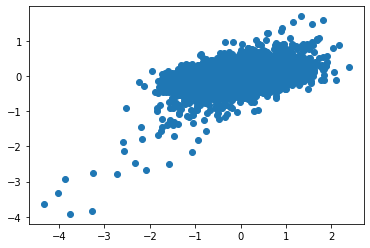

In [80]:
plt.scatter(vals+noise, vals)

(array([8.000e+00, 5.000e+00, 8.000e+00, 1.290e+02, 1.682e+03, 6.043e+03,
        7.305e+03, 2.857e+03, 3.700e+02, 1.100e+01]),
 array([-3.71561974, -3.1133462 , -2.51107266, -1.90879912, -1.30652558,
        -0.70425204, -0.1019785 ,  0.50029504,  1.10256858,  1.70484212,
         2.30711566]),
 <BarContainer object of 10 artists>)

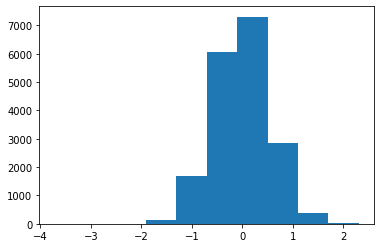

In [73]:
plt.hist(vals+noise)

In [84]:
with h5py.File(filename, 'r') as f:
    covariates = f['covariates'][:]
    print(covariates)

[[ 0.8664957 ]
 [-0.19948187]
 [-0.66753256]
 ...
 [ 0.12752467]
 [ 0.11362068]
 [ 1.5334302 ]]


In [16]:
noisy_data

NameError: name 'noisy_data' is not defined

In [82]:
#vals = pd.read_csv('/dfs/scratch0/jianv/bio-logs/noisy-data/ground_truth_IFNG_0.1.csv')['Score'].values

In [83]:
with h5py.File(filename, 'r+') as f:
    
    # Update the dataset with new values
    f['covariates'][...] = np.expand_dims(noisy_data, 1)

### Combinatorial results: Horlbeck

In [75]:
ground_truth_horlbeck = pd.read_csv('/dfs/user/yhr/testing/research_assistant/datasets/ground_truth_Horlbeck.csv')

topmovers_horlbeck = np.load('/dfs/user/yhr/testing/research_assistant/datasets/topmovers_Horlbeck.npy')
topmovers_horlbeck = [str((x[0], x[1])) for x in topmovers_horlbeck]

In [69]:
idx = ['negative' not in x for x in ground_truth_horlbeck['Gene_pairs']]
ground_truth_horlbeck_subset = ground_truth_horlbeck[idx]
available_combos = ground_truth_horlbeck_subset['Gene_pairs'].tolist()


In [125]:
random_rounds = {}
random_scores = {}
cum_scores = {}
num_steps = 5

batch_size = 32
for itr in range(10):
    random_rounds[itr] = []
    random_scores[itr] = []
    cum_scores[itr] = []
    cum_sample = []
    
    for step in range(num_steps):
        sample = np.random.choice(available_combos, batch_size)
        cum_sample.extend(sample)
        random_rounds[itr].append(cum_sample)
        available_combos = list(set(available_combos).difference(set(cum_sample)))
        random_scores[itr].append(len(set(cum_sample).intersection(set(topmovers_horlbeck))))

In [126]:
means = np.mean(list(random_scores.values()),0)
std = np.std(list(random_scores.values()),0)

In [136]:
pred_rounds = {}
pred_scores = {}
pred_cum_scores = {}

batch_size = 32
for itr in range(6):
    pred_rounds[itr] = []
    pred_scores[itr] = []
    pred_cum_scores[itr] = []
    
    for step in range(5):
        pred_sample = np.load(f'/dfs/user/yhr/testing/research_assistant/logs_Horlbeck/exp_{itr+1}/sampled_genes_{step+1}.npy')
        pred_sample = [str((x[0], x[1])) for x in pred_sample]
        pred_rounds[itr].append(pred_sample)
        pred_scores[itr].append(len(set(pred_sample).intersection(set(topmovers_horlbeck))))

In [138]:
pred_means = np.mean(list(pred_scores.values()),0)
pred_std = np.std(list(pred_scores.values()),0)

Text(0.5, 0, 'Experimental rounds')

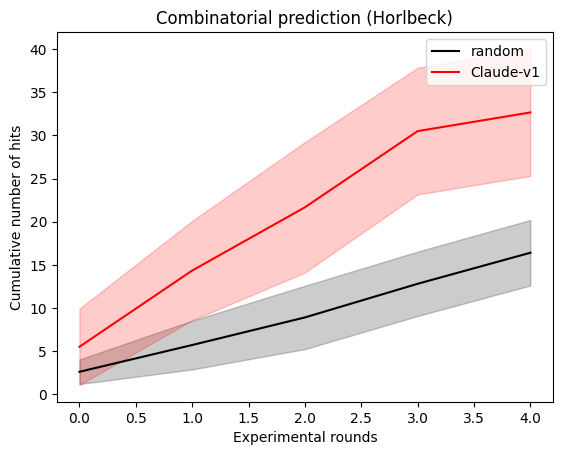

In [141]:
plt.plot(np.arange(num_steps), 
         means, label='random', color='black')
plt.fill_between(np.arange(num_steps), 
                 means - std, 
                 means + std,
                 color='black', alpha=0.2)

plt.plot(np.arange(num_steps), 
         pred_means, label='Claude-v1', color='red')
plt.fill_between(np.arange(num_steps), 
                 pred_means - pred_std, 
                 pred_means + pred_std,
                 color='red', alpha=0.2)


plt.legend()
plt.title('Combinatorial prediction (Horlbeck)')
plt.ylabel('Cumulative number of hits')
plt.xlabel('Experimental rounds')

In [142]:
pred_means

array([ 5.5       , 14.33333333, 21.66666667, 30.5       , 32.66666667])

In [148]:
pred_std

array([4.42530602, 5.76387216, 7.56453715, 7.34279692, 7.36357401])

In [144]:
means

array([ 2.6,  5.7,  8.9, 12.8, 16.4])

In [149]:
std

array([1.42828569, 2.83019434, 3.67287353, 3.73630834, 3.8       ])

### Combinatorial results: Norman

In [206]:
ground_truth_norman = pd.read_csv('/dfs/user/yhr/testing/research_assistant/datasets/ground_truth_NormanGI.csv')

topmovers_norman = np.load('/dfs/user/yhr/testing/research_assistant/datasets/topmovers_NormanGI.npy')
topmovers_norman = [str((x[0], x[1])) for x in topmovers_norman]

In [217]:
idx = ['negative' not in x for x in ground_truth_norman['Gene_pairs']]
ground_truth_norman_subset = ground_truth_norman[idx]
available_combos = ground_truth_norman_subset['Gene_pairs'].tolist()


In [218]:
random_rounds = {}
random_scores = {}
cum_scores = {}
num_steps = 5

batch_size = 32
for itr in range(10):
    random_rounds[itr] = []
    random_scores[itr] = []
    cum_scores[itr] = []
    cum_sample = []
    
    for step in range(num_steps):
        sample = np.random.choice(available_combos, batch_size)
        cum_sample.extend(sample)
        random_rounds[itr].append(cum_sample)
        available_combos = list(set(available_combos).difference(set(cum_sample)))
        random_scores[itr].append(len(set(cum_sample).intersection(set(topmovers_norman))))

In [219]:
means = np.mean(list(random_scores.values()),0)
std = np.std(list(random_scores.values()),0)

In [220]:
means

array([ 3.3,  5.9, 10.7, 13.8, 17.2])

In [221]:
std

array([1.61554944, 1.97230829, 2.00249844, 1.93907194, 3.02654919])

In [228]:
pred_rounds = {}
pred_scores = {}
pred_cum_scores = {}

batch_size = 32
for itr in range(1,5):
    pred_rounds[itr] = []
    pred_scores[itr] = []
    pred_cum_scores[itr] = []
    
    for step in range(5):
        pred_sample = np.load(f'/dfs/user/yhr/testing/research_assistant/logs_NormanGI/exp_{itr+1}/sampled_genes_{step+1}.npy')
        pred_sample = [str((x[0], x[1])) for x in pred_sample]
        pred_rounds[itr].append(pred_sample)
        pred_scores[itr].append(len(set(pred_sample).intersection(set(topmovers_norman))))

In [229]:
pred_means = np.mean(list(pred_scores.values()),0)
pred_std = np.std(list(pred_scores.values()),0)

Text(0.5, 0, 'Experimental rounds')

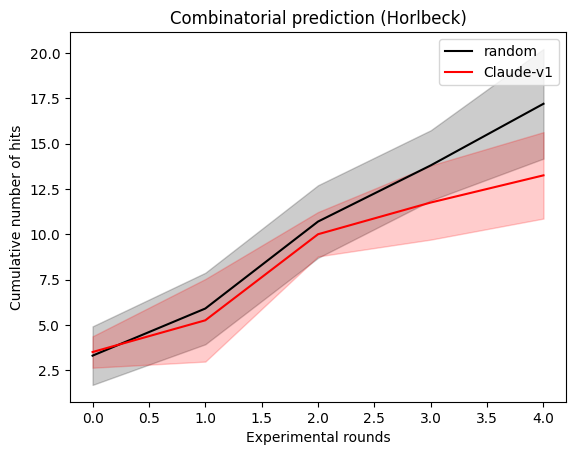

In [230]:
plt.plot(np.arange(num_steps), 
         means, label='random', color='black')
plt.fill_between(np.arange(num_steps), 
                 means - std, 
                 means + std,
                 color='black', alpha=0.2)

plt.plot(np.arange(num_steps), 
         pred_means, label='Claude-v1', color='red')
plt.fill_between(np.arange(num_steps), 
                 pred_means - pred_std, 
                 pred_means + pred_std,
                 color='red', alpha=0.2)


plt.legend()
plt.title('Combinatorial prediction (Horlbeck)')
plt.ylabel('Cumulative number of hits')
plt.xlabel('Experimental rounds')

In [231]:
pred_means

array([ 3.5 ,  5.25, 10.  , 11.75, 13.25])

In [232]:
pred_std

array([0.8660254 , 2.27760839, 1.22474487, 2.04633819, 2.384848  ])

In [144]:
means

array([ 2.6,  5.7,  8.9, 12.8, 16.4])

In [149]:
std

array([1.42828569, 2.83019434, 3.67287353, 3.73630834, 3.8       ])